In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import os
from easydict import EasyDict as edict
from torch.nn import functional as F
import numpy as np

In [ ]:
pip install torchsummary

In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/YOLO trainer')
from models import *
from train import *
from dataset import *

In [ ]:
''''%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)'''

'\'%tensorflow_version 2.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\n\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)'

In [ ]:
# Download the specific version of libraries that YOLO requires
!pip install -r "/content/drive/My Drive/Colab Notebooks/YOLO trainer/requirements.txt"

In [ ]:
# download pretrained yolo weights
!gdown https://drive.google.com/uc?id=1fcbR0bWzYfIEdLJPzOsn4R5mlvR6IQyA

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/YOLO trainer"
#%rm -r "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/test"
#%rm -r "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/train"
#%rm -r "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/valid"
#%mkdir "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/data"


In [ ]:
def num(path):
  # returns the number of classes we have
  classes = 0
  with open(path, 'r') as f:
      lines = f.readlines()
  for line in lines:
        classes+=1
  return classes 

num = num('/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins2/train/_classes.txt')

In [ ]:
print(num)

6


In [ ]:
# Configuration
from easydict import EasyDict
from config import Cfg

# Yolov4 configurations
Cfg.pretrained = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/yolov4.conv.137.pth"
#Cfg.pretrained = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/trained/final.pth"
# Directory to train images and label
Cfg.dataset_dir = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins2/train"
Cfg.train_label = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins2/train/_annotations.txt"
Cfg.val_label = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins2/valid/_annotations.txt"

Cfg.seed = 2000

Cfg.TRAIN_EPOCHS = 150

Cfg.batch = 4
Cfg.learning_rate = 0.001 / Cfg.batch
Cfg.classes = num
Cfg.TRAIN_OPTIMIZER = 'adam'

# Where to save the models (at checkpoint and final)
Cfg.checkpoints = '/content/drive/My Drive/Colab Notebooks/YOLO trainer/trained'
Cfg.subdivisions = 1

Cfg.width = 608
Cfg.height = 608
Cfg.channels = 3
Cfg.w = Cfg.width
Cfg.h = Cfg.height


In [ ]:
from torch.utils.data.dataset import Dataset

import random
import cv2
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
f = open("/content/drive/My Drive/Colab Notebooks/YOLO trainer/testing.txt", 'r', encoding='utf-8')
truth1 = {}
truth2 = {}
for line in f.readlines():
    data = line.split(" ")
    truth1[data[0]] = []
    for i in data[1:]:
        truth1[data[0]].append([int(j) for j in i.split(',')])
path = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testing.txt"
print(truth1)
with open(path, 'r') as f:
    lines = f.readlines()
for line in lines:
    l = []
    info = line.split(" ")
    for i in info[1:]:
        l += [[int(j) for j in i.split(',')]]
    truth2[info[0]] = l

print(truth2.keys())
img_path = list(truth2.keys())[0]
box = np.array(list(truth2.values())[0])
box2 = np.array(truth2.get(img_path), dtype=np.float)
print(box == box2)
print(f"{Cfg.dataset_dir}/{img_path}")

#print(img_path)
img_path = os.path.join(Cfg.dataset_dir, img_path)
print(img_path)
#print(box)
img = cv2.imread(img_path)
oh, ow, oc = 416,416,3
dh, dw, dc = np.array(np.array([oh, ow, oc]) * 0.2, dtype=np.int)
print(int(416*0.2))
print((dh))
print(dw)
print(dc)


In [ ]:
import random

def rand_uniform_strong(min, max):
    return random.random()*(max - min) + min
use_mixup = 1
i = random.randint(-1, 1)
if i:
        use_mixup = 0
print(i)

print(use_mixup)
for i in range(1):
    print(i)
dhue = rand_uniform_strong(-0.1, 0.1)

print(dhue)

if (Cfg.blur):
    tmp_blur = random.randint(0, 2)  # 0 - disable, 1 - blur background, 2 - blur the whole image
    if tmp_blur == 0:
                    print("OK")
                    blur = 0
    elif tmp_blur == 1:
                    print("OK")
                    blur = 1
    else:
                    print("OK")
                    blur = self.cfg.blur


In [ ]:
import random
class dataset_yolo(Dataset):
    def __init__(self, labelpath, cfg):
        super(Yolo_dataset, self).__init__()

        # Extracting the links and bounding box information from txt files
        with open(labelpath, 'r') as f:
            data = {}
            lines = f.readlines()
        for line in lines:
            l_append = []
            info = line.split(" ")
            for i in info[1:]:
                l_append += [[int(boxes) for boxes in i.split(',')]]
            data[info[0]] = l_append

        self.data = data
        self.config = cfg
        pass

    def __len__(self):
        print(f" The keys are {self.data.keys}")
        return len(self.data.keys())

    def __getitem__(self, index):
        # outputs as augmented img and their boxes
        height = self.config.height
        width = self.config.width
        channel = self.config.channel
        img_output = np.zeros([height, width, channel])
        box_output = []

        # Get the path to the images and their information
        imgpath = list(self.data.keys())[index]
        box = np.array(list(truth2.values())[index])
        box = np.array(self.truth.get(imgpath)
        full_img_path = f"{self.config.dataset_dir}/{imgpath}"

        # Data Augmentation

        # Random mixup on images with self.config number of images or don't use at all
        use_mixup = self.config if random.randint(0,1) else 0

        if use_mixup:
            # Random numbers to cut the image in x and y directions
            cut_x = random.randint(width*0.2), int(width* (0.8)))
            cut_y = random.randint(height*0.2), int(height* (0.8)))
        
        # Variables
        r1, r2, r3, r4, r_scale = 0, 0, 0, 0, 0
        dhue, dsat, dexp, flip, blur = 0, 0, 0, 0, 0
        rotate = 0
        gaussian_noise = 0

        for i in range(use_mixup + 1):
           if i != 0:
                # Get random image to mixup with
                img2 = random.choice(list(self.truth.keys()))
                box2 = np.array(self.truth.get(img2)
                full_img_path2 = f"{self.config.dataset_dir}/{img2}"
            img = cv2.imread(full_img_path2)
            if img is None:
                continue
            # convert from bgr to rgb (because opencv is weird in this way)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            dh, dw, dc = int(height*0.2), int(width*0.2), int(channel*0.2)

            dhue = rand_uniform_strong(-self.cfg.hue, self.cfg.hue)
            dsat = rand_scale(self.cfg.saturation)
            dexp = rand_scale(self.cfg.exposure)

            pleft = random.randint(-dw, dw)
            pright = random.randint(-dw, dw)
            ptop = random.randint(-dh, dh)
            pbot = random.randint(-dh, dh)

        swidth = ow - pleft - pright
        sheight = oh - ptop - pbot
        flip = random.randint(0, 1) if self.cfg.flip else 0
        truth, min_w_h = fill_truth_detection(bboxes, self.cfg.boxes, self.cfg.classes, flip, pleft, ptop, swidth,
                                                  sheight, self.cfg.w, self.cfg.h)

        ai = image_data_augmentation(img, self.cfg.w, self.cfg.h, pleft, ptop, swidth, sheight, flip,
                                         dhue, dsat, dexp, gaussian_noise, blur, truth)
        
        if use_mixup == 0:
                img_output = ai
                box_output = truth

        else:
            if flip:
                tmp = pleft
                pleft = pright
                 pright = tmp

            left_shift = int(min(cut_x, max(0, (-int(pleft) * self.cfg.w / swidth))))
            top_shift = int(min(cut_y, max(0, (-int(ptop) * self.cfg.h / sheight))))

            right_shift = int(min((self.cfg.w - cut_x), max(0, (-int(pright) * self.cfg.w / swidth))))
            bot_shift = int(min(self.cfg.h - cut_y, max(0, (-int(pbot) * self.cfg.h / sheight))))

            img_output, out_bbox = blend_truth_mosaic(img_output, ai, truth.copy(), self.cfg.w, self.cfg.h, cut_x,
                                                       cut_y, i, left_shift, right_shift, top_shift, bot_shift)
            box_output.append(out_bbox)

        if use_mixup != 0:
            box_output = np.concatenate(box_output, axis=0)
        box_output = np.zeros([self.cfg.boxes, 5])
        box_output[:min(box_output.shape[0], self.cfg.boxes)] = box_output[:min(box_output.shape[0], self.cfg.boxes)]
        return img_output, box_output



        pass

SyntaxError: ignored

In [ ]:
# Data Augmentation

def image_data_augmentation():
    return

# Mosaic For scale and translation augmentation
def mosaic():
    return

# Flip 
def flip(img):
    return img

# Rotate for rotational 
def Rotate(img):
    return img

# Decolourized
 def decolourized(img):
     return

# Mixup
def mixup(img):
    return
    
# RGB to HSV applies a Mask on the coins
def RGBtoHSV(img):
    return

def gaussianblur(img):
    return

In [ ]:
def draw_box(img, bboxes):
    for b in bboxes:
        img = cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    return img

In [ ]:
import re
def add_path(path, path_to_add):
    # adds the correct path to the txt files
    info = open(path, 'r')
    final = []
    with info as draw:
        lines = draw.readlines()
        print(lines)
    for l in lines:
        as_list = re.split(" |\n", l)
        as_list[0] = str(path_to_add)+ str(as_list[0])
        final.append(as_list)
    with open(path, 'w') as f:
        for i in range(len(final)):
            for j in range(len(final[i])):
                f.write(f"{final[i][j]} ")
            f.write("\n")
    return


In [ ]:
#add_path("/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/valid/valdata.txt", "'/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/valid/'")
#add_path("/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/train/traindata.txt", "'/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/train/'")

In [ ]:
import matplotlib.pyplot as plt
# test
img =plt.imread("/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/train/IMG_3974_jpeg.rf.7c8b90fd22627c74036628d96a76be93.jpg")
plt.imshow(img)
print(np.shape(img))

In [ ]:



def loadmodel(lr, batch, n_classes, device, config):
    def update_lr(epoch_num):
    # adjust the learning rate based on the number of epochs. 
    # learning rate setup
        if epoch_num < config.burn_in:
            lambda1 = (epoch_num / config.burn_in)**4
        elif epoch_num < config.steps[0]:
            lambda1 = 1.0
        elif epoch_num < config.steps[1]:
            lambda1 = 0.1
        else:
            lambda1 = 0.01
        return lambda1
    # Use adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Updates the learning rate based on the number of epochs
    # This might prove useful if we have a large number of epochs
    # but we might not need it
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, update_lr, last_epoch=-1)
    criterion = Yolo_loss(device=device, batch=batch,n_classes=config.classes)
    return optimizer, scheduler, criterion

def train(model, device, config, epochs=50, batch_size=2):
    loss1,lossxy1,losswh1,lossobj1,losscls1,loss121 = [],[],[],[],[],[]
    batch_size = config.batch
    lr = config.learning_rate
    step = 0
    loss = 0
    num_class = config.classes

    train_dataset = Yolo_dataset(config.train_label, config)
    val_dataset = Yolo_dataset(config.val_label, config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=8, pin_memory=True, drop_last=True, collate_fn=collate)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
                            pin_memory=True, drop_last=True)
    print("Done Loading Dataset")
    optimizer, scheduler, criterion = loadmodel(lr, batch_size, num_class, device, config)
    model.train()
    for epoch in range(epochs):
            print(f"epoch is {epoch}")
            for i, batch in enumerate(train_loader):
                step += 1
                
                images = batch[0]
                label = batch[1]
                #orig = batch[2]
                #print(np.shape(orig))

                images = images.to(device=device, dtype=torch.float32)
                #print(np.shape(images))
                label = label.to(device=device)
                label_pred = model(images)
                #print(type(label_pred[0]))
                #print(type(label))
                #print(label)
                #plt.imshow(label.cpu()[0].permute(1, 2, 0))
                #print(np.shape(label_pred[1]))
                #print(label_pred)
                loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2 = criterion(label_pred, label)

                # Every when should we update the values
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                loss.backward()


                if i % 50 == 0:
                    print(f"Epoch {epoch} | loss: {loss}, loss_xy: {loss_xy}, loss_wh: {loss_wh},loss_obj: {loss_obj},loss_cls: {loss_cls}, loss_12: {loss_l2}")
                    loss1.append(loss)
                    lossxy1.append(loss_xy)
                    losswh1.append(loss_wh)
                    lossobj1.append(loss_obj)
                    losscls1.append(loss_cls)
                    loss121.append(loss_l2)
            if (epoch%10==0 or epoch == epochs-1):
                torch.save(model.state_dict(), f"{config.checkpoints}/Yolo-{epoch + 1}.pt")

    return model, loss1, lossxy1, losswh1, lossobj1, losscls1, loss121

In [ ]:
from torchsummary import summary
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Yolov4(Cfg.pretrained,n_classes=Cfg.classes)
    #with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    #    model = Yolov4(Cfg.pretrained,n_classes=Cfg.classes)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model.to(device=device)
    model_final, loss1, lossxy1, losswh1, lossobj1, losscls1, loss121 = train(model=model, config=Cfg, epochs=Cfg.TRAIN_EPOCHS, device=device )

Done Loading Dataset
epoch is 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 | loss: 65523.796875, loss_xy: 100.35445404052734, loss_wh: 26.051651000976562,loss_obj: 65246.25,loss_cls: 151.14041137695312, loss_12: 23841.35546875
epoch is 1
Epoch 1 | loss: 65485.6640625, loss_xy: 91.85702514648438, loss_wh: 14.98975944519043,loss_obj: 65235.96484375,loss_cls: 142.85208129882812, loss_12: 23790.97265625
epoch is 2
Epoch 2 | loss: 65466.4609375, loss_xy: 73.1325454711914, loss_wh: 16.541099548339844,loss_obj: 65265.16796875,loss_cls: 111.62060546875, loss_12: 23815.994140625
epoch is 3
Epoch 3 | loss: 65411.0703125, loss_xy: 71.71705627441406, loss_wh: 12.612720489501953,loss_obj: 65219.734375,loss_cls: 107.00941467285156, loss_12: 23794.771484375
epoch is 4
Epoch 4 | loss: 65387.546875, loss_xy: 102.48487854003906, loss_wh: 15.529895782470703,loss_obj: 65114.55859375,loss_cls: 154.97201538085938, loss_12: 23776.11328125
epoch is 5
Epoch 5 | loss: 65097.20703125, loss_xy: 108.7415542602539, loss_wh: 16.94265365600586,loss_obj: 64808.95703125,loss_cls: 162.

In [ ]:
summary(model, (3,608,608))

In [ ]:
torch.save(model_final.state_dict(), os.path.join(Cfg.checkpoints, "model_final2.pt"))

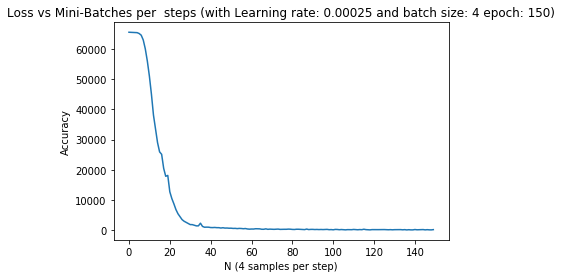

In [ ]:
figure = plt.figure()
x6 = np.arange(0,len(loss1),1)
#y_2 = savgol_filter(loss1, 51,5)
plt.plot(x6, loss1)

plt.xlabel(f"N ({Cfg.batch} samples per step)")
plt.ylabel("Accuracy")
plt.title(f"Loss vs Mini-Batches per  steps (with Learning rate: {Cfg.learning_rate} and batch size: {Cfg.batch} epoch: {Cfg.TRAIN_EPOCHS})")
plt.show()

FileNotFoundError: ignored

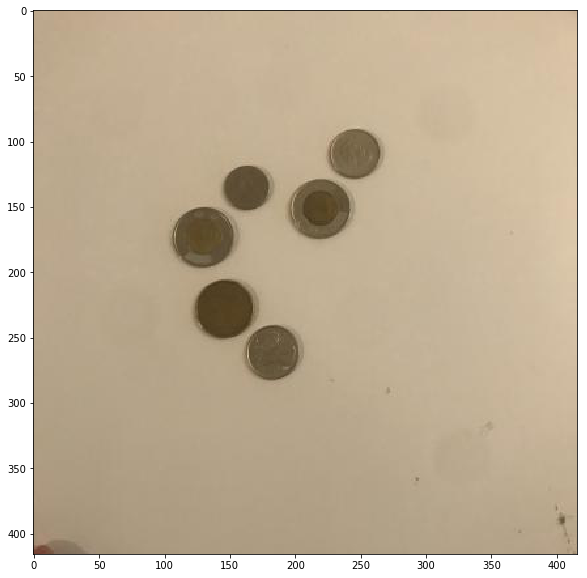

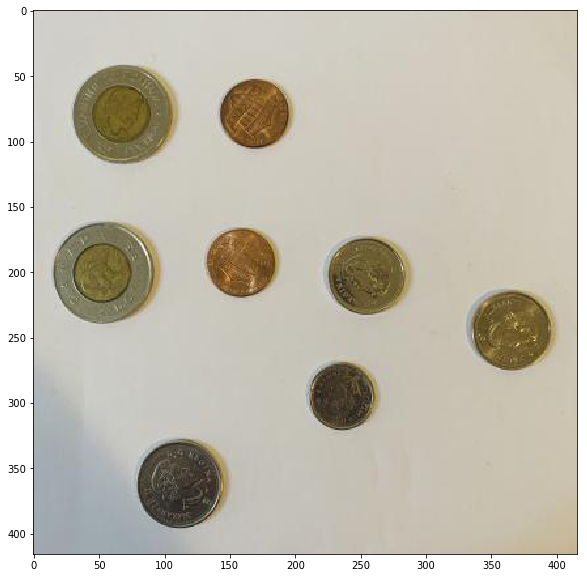

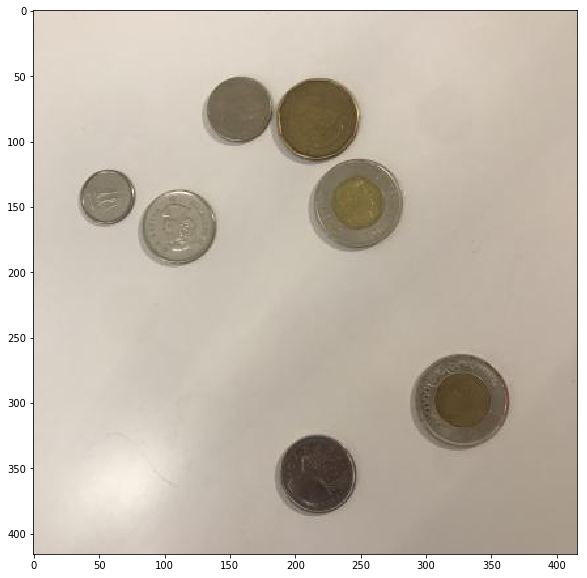

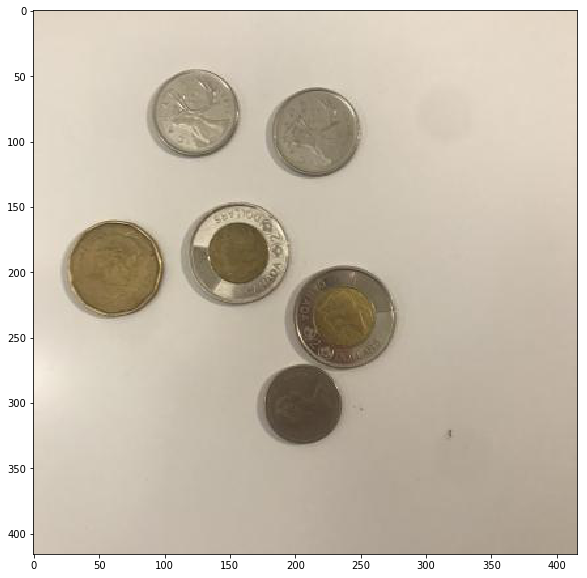

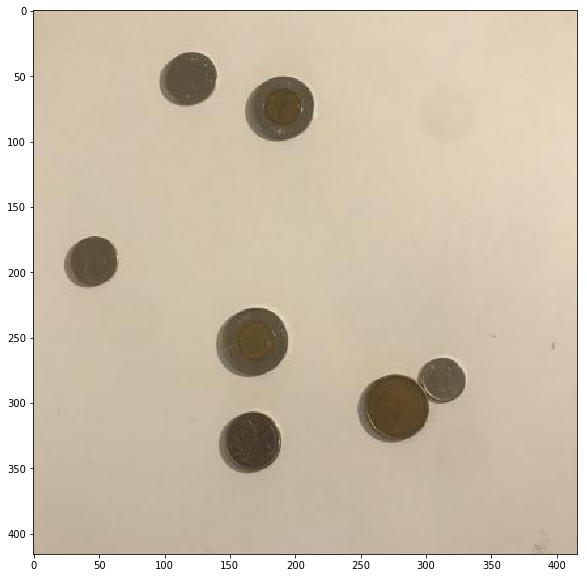

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
test_images = [f for f in os.listdir('/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train') if f.endswith('.jpg')]
test_images2 = [f for f in os.listdir('/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train') if f.endswith('.jpg')]
test_images3 = [f for f in os.listdir('/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train') if f.endswith('.jpg')]
test_images4 = [f for f in os.listdir('/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train') if f.endswith('.jpg')]
test_images5 = [f for f in os.listdir('/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train') if f.endswith('.jpg')]

figure = plt.figure(figsize=(20,10))
img_path = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train/" + random.choice(test_images);
img_path2 = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train/" + random.choice(test_images2);
img_path3 = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train/" + random.choice(test_images3);
img_path4 = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train/" + random.choice(test_images4);
img_path5 = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/testingdata/train/" + random.choice(test_images5);
img1 = plt.imread(img_path)
plt.imshow(img1)
figure = plt.figure(figsize=(20,10))
img1 = plt.imread(img_path2)
plt.imshow(img1)
figure = plt.figure(figsize=(20,10))
img1 = plt.imread(img_path3)
plt.imshow(img1)
figure = plt.figure(figsize=(20,10))
img1 = plt.imread(img_path4)
plt.imshow(img1)
figure = plt.figure(figsize=(20,10))
img1 = plt.imread(img_path5)
plt.imshow(img1)

In [ ]:
path_to_model = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/trained/model_final2.pt"
path_to_model2 = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/trained/final.pth"

In [ ]:
model_test = Yolov4(n_classes=num)
pretrained_dict = torch.load(path_to_model, map_location=torch.device('cpu'))
model_test.load_state_dict(pretrained_dict)


<All keys matched successfully>

In [ ]:
model_test.cuda()

In [ ]:
import sys
import os
import time
import math
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import itertools
import struct 
import imghdr  
import cv2

colors = torch.FloatTensor([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]]);
def get_color(c, x, max_val):
    ratio = float(x) / max_val * 5
    i = int(math.floor(ratio))
    j = int(math.ceil(ratio))
    ratio = ratio - i
    r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
    return int(r * 255)

def get_value(class_list):
    two = class_list.count("$2.00")
    one = class_list.count("$1.00")
    quart = class_list.count("$0.25")
    dime  = class_list.count("$0.10")
    nickel = class_list.count("$0.05")
    penny = class_list.count("$0.01")
    return two*2 + one*1 + quart*0.25 + dime*0.10 + nickel*0.05 + penny*0.01

def drawboxes2(img, bb, savepath=None, class_list=None, color=None):
    w = img.width
    h = img.height
    total = []
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/content/drive/My Drive/Colab Notebooks/YOLO trainer/Kalam-Bold.ttf", 25)
    font2 = ImageFont.truetype("/content/drive/My Drive/Colab Notebooks/YOLO trainer/Kalam-Bold.ttf", 18)
    print("o-----------------------o")
    print("|         Coins         |")
    for i in range(len(bb)):
        box = bb[i]
        x1 = w*(box[0]-box[2]/2.0)
        y1 = h*(box[1]-box[3]/2.0)
        x2 = w*(box[0]+box[2]/2.0)
        y2 = h*(box[1]+box[3]/2.0)

        rgb = (255, 0, 0)
        if len(box) >= 7 and class_list != None:

            pred = box[5]
            id = box[6]
            print("o-----------------------o")
            print("|" + str(class_list[id]).replace('\n','') + "\t:\t" + str(f"{pred*100:0.1f}%\t|"))
            classes = len(class_list)        
            offset = id * 123457 % classes
            red = get_color(2, offset, classes)
            green = get_color(1, offset, classes)
            blue = get_color(0, offset, classes)
            rgb = (red, green, blue)
            draw.rectangle([x1, y1, x2, y2], outline=rgb,width=2)
            draw.text(((x1+x2)//2, (y1+y2)//2), class_list[id], fill=(255,255,255),outline=(255,255,255), font = font2)
            draw.text((-2+(x1+x2)//2, -(y2//18)+(y1+y2)//2), str(f"{pred*100:.1f}%"), fill=(rgb))
        draw.rectangle([0,0,70,40], fill=(168,250,165))
        total += [class_list[id].replace("\n",'')]
    print("o-----------------------o")
    value = get_value(total)
    print(f"|Total \t=       ${value:0.2f}\t|")
    print("o=======================o\n")
    draw.text((0, 0), str(f"${value:.2f}")[0:5], fill=(0,0,0), font = font)
    if savepath:
        img.save(savepath)
    return img

o-----------------------o
|         Coins         |
o-----------------------o
|$0.05	:	61.1%	|
o-----------------------o
|$2.00	:	99.9%	|
o-----------------------o
|$1.00	:	98.0%	|
o-----------------------o
|$0.25	:	49.3%	|
o-----------------------o
|$0.10	:	89.1%	|
o-----------------------o
|$0.05	:	37.3%	|
o-----------------------o
|Total 	=       $3.45	|
o=======================o



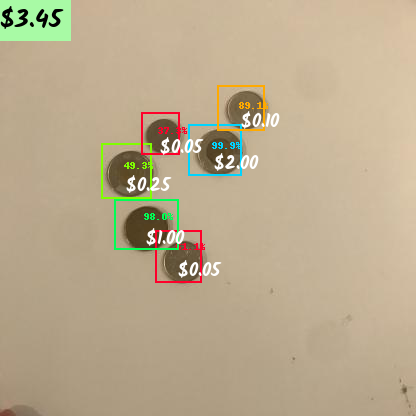

In [ ]:
import sys
import PIL
from utils import *
from IPython.display import Image
def loadnames(path):
    classes = []
    with open(path, 'r') as f:
      lines = f.readlines()
    for line in lines:
        classes.append(line)
    return classes 

class_path = "/content/drive/My Drive/Colab Notebooks/YOLO trainer/Coins/test/classes.txt"
use_cuda = 1
img = PIL.Image.open(img_path).convert('RGB')
sized = img.resize((500, 500))
boxes = do_detect(model_test, sized, 0.5, num, 0.4, use_cuda)
class_names = loadnames(class_path)
drawboxes2(img, boxes, '/content/drive/My Drive/Colab Notebooks/YOLO trainer/prediction.jpg', class_names)

o-----------------------o
|         Coins         |
o-----------------------o
|$0.10	:	86.3%	|
o-----------------------o
|$0.01	:	100.0%	|
o-----------------------o
|$0.01	:	100.0%	|
o-----------------------o
|$1.00	:	63.3%	|
o-----------------------o
|$2.00	:	100.0%	|
o-----------------------o
|$0.05	:	100.0%	|
o-----------------------o
|$0.05	:	100.0%	|
o-----------------------o
|$2.00	:	100.0%	|
o-----------------------o
|Total 	=       $5.22	|
o=======================o



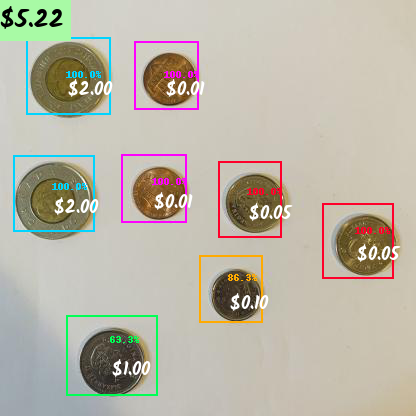

In [ ]:
img = PIL.Image.open(img_path2).convert('RGB')
boxes = do_detect(model_test, img.resize((500, 500)), 0.5, num,0.4, use_cuda)
class_names = loadnames(class_path)
drawboxes2(img, boxes, '/content/drive/My Drive/Colab Notebooks/YOLO trainer/prediction2.jpg', class_names)


o-----------------------o
|         Coins         |
o-----------------------o
|$0.01	:	100.0%	|
o-----------------------o
|$0.10	:	100.0%	|
o-----------------------o
|$0.01	:	100.0%	|
o-----------------------o
|$0.05	:	100.0%	|
o-----------------------o
|$0.05	:	100.0%	|
o-----------------------o
|$0.25	:	100.0%	|
o-----------------------o
|$2.00	:	100.0%	|
o-----------------------o
|Total 	=       $2.47	|
o=======================o



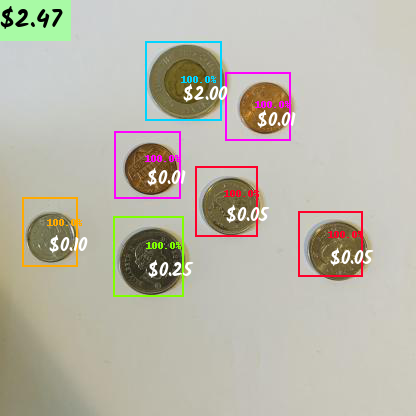

In [ ]:
img = PIL.Image.open(img_path3).convert('RGB')
boxes = do_detect(model_test, img.resize((500, 500)), 0.5, num,0.4, use_cuda)
class_names = loadnames(class_path)
drawboxes2(img, boxes, '/content/drive/My Drive/Colab Notebooks/YOLO trainer/prediction3.jpg', class_names)

o-----------------------o
|         Coins         |
o-----------------------o
|$0.25	:	77.6%	|
o-----------------------o
|$1.00	:	97.7%	|
o-----------------------o
|$2.00	:	99.9%	|
o-----------------------o
|$0.05	:	58.0%	|
o-----------------------o
|$2.00	:	100.0%	|
o-----------------------o
|$1.00	:	94.5%	|
o-----------------------o
|Total 	=       $6.30	|
o=======================o



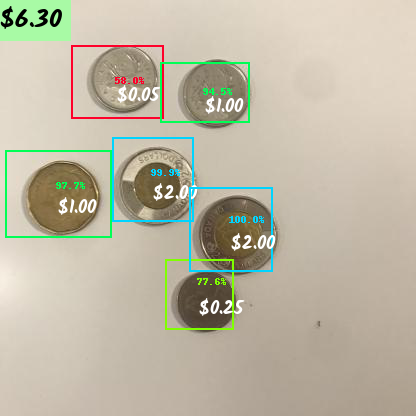

In [ ]:
img = PIL.Image.open(img_path4).convert('RGB')
boxes = do_detect(model_test, img.resize((500, 500)), 0.5, num,0.4, use_cuda)
class_names = loadnames(class_path)
drawboxes2(img, boxes, '/content/drive/My Drive/Colab Notebooks/YOLO trainer/prediction4.jpg', class_names)


o-----------------------o
|         Coins         |
o-----------------------o
|$1.00	:	99.4%	|
o-----------------------o
|$2.00	:	65.9%	|
o-----------------------o
|$2.00	:	100.0%	|
o-----------------------o
|$0.10	:	72.5%	|
o-----------------------o
|$0.25	:	88.0%	|
o-----------------------o
|$0.10	:	98.6%	|
o-----------------------o
|$0.25	:	95.8%	|
o-----------------------o
|Total 	=       $5.70	|
o=======================o



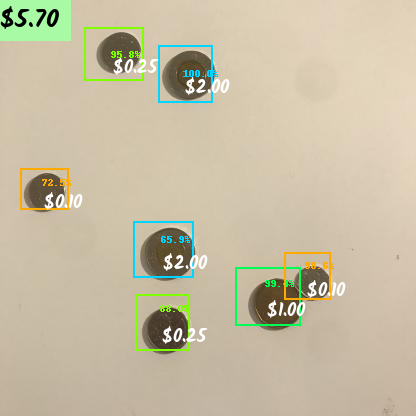

In [ ]:
img = PIL.Image.open(img_path5).convert('RGB')
boxes = do_detect(model_test, img.resize((500, 500)), 0.5, num,0.4, use_cuda)
class_names = loadnames(class_path)
drawboxes2(img, boxes, '/content/drive/My Drive/Colab Notebooks/YOLO trainer/prediction5.jpg', class_names)